# Nozzle design

In [1]:
# this line makes figures interactive in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

# we can use this to solve nonlinear/transcendental equations
from scipy.optimize import root_scalar

In [9]:
# these lines are only for helping improve the display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['mathtext.fontset'] = 'cm'

While we have seen how to calculate the nozzle throat and exit diameters, what about the length? And, for that matter, what about the shape of the nozzle? (This applies specifically to the diverging section of the nozzle.) 

We have a two main options: conical and bell shapes.

### Conical nozzle 

:::{figure} ../images/conical-nozzle.svg
:label: fig-conical-nozzle
:alt: Diagram of a conical nozzle shape
:align: center
:width: 80%

Conical nozzle shaped nozzle (diverging section), with half angle $\alpha$, throat radius $r_t$, exit radius $r_e$, and length $L$.
:::

A simple design for the diverging section is a **conical nozzle**, as [](#fig-conical-nozzle) shows, which is based on a [frustrum](https://en.wikipedia.org/wiki/Frustum) of a cone (or truncated cone).

The length $L$ of a conical nozzle is based on the expansion angle of the cone $\alpha$ (also called the half angle) and radii at the throat and exit:

$$
L = \frac{r_e - r_t}{\tan \alpha} \;,
$$

where the area ratio of the nozzle also relates the radii:

$$
\epsilon = \frac{A_e}{A_t} = \frac{r_e^2}{r_t^2} \;.
$$

:::{note}
Typical conical nozzles use an expansion angle of 15°.
:::

The conical nozzle is simple to design and manufacture, and so is often used for amateur and student-built rocket nozzles. However, some of the flow is directed out at an angle, which reduces the actual thrust from the ideal thrust (if all the flow were directed axially). This is reflected in a thrust correction factor $\lambda$:

$$
\lambda = \frac{1 + \cos \alpha}{2} \;,
$$

which applies only to the momentum/exhaust velocity term of thrust and not the pressure term.
We can examine the impact of this correction for a range of cone expansion angles:

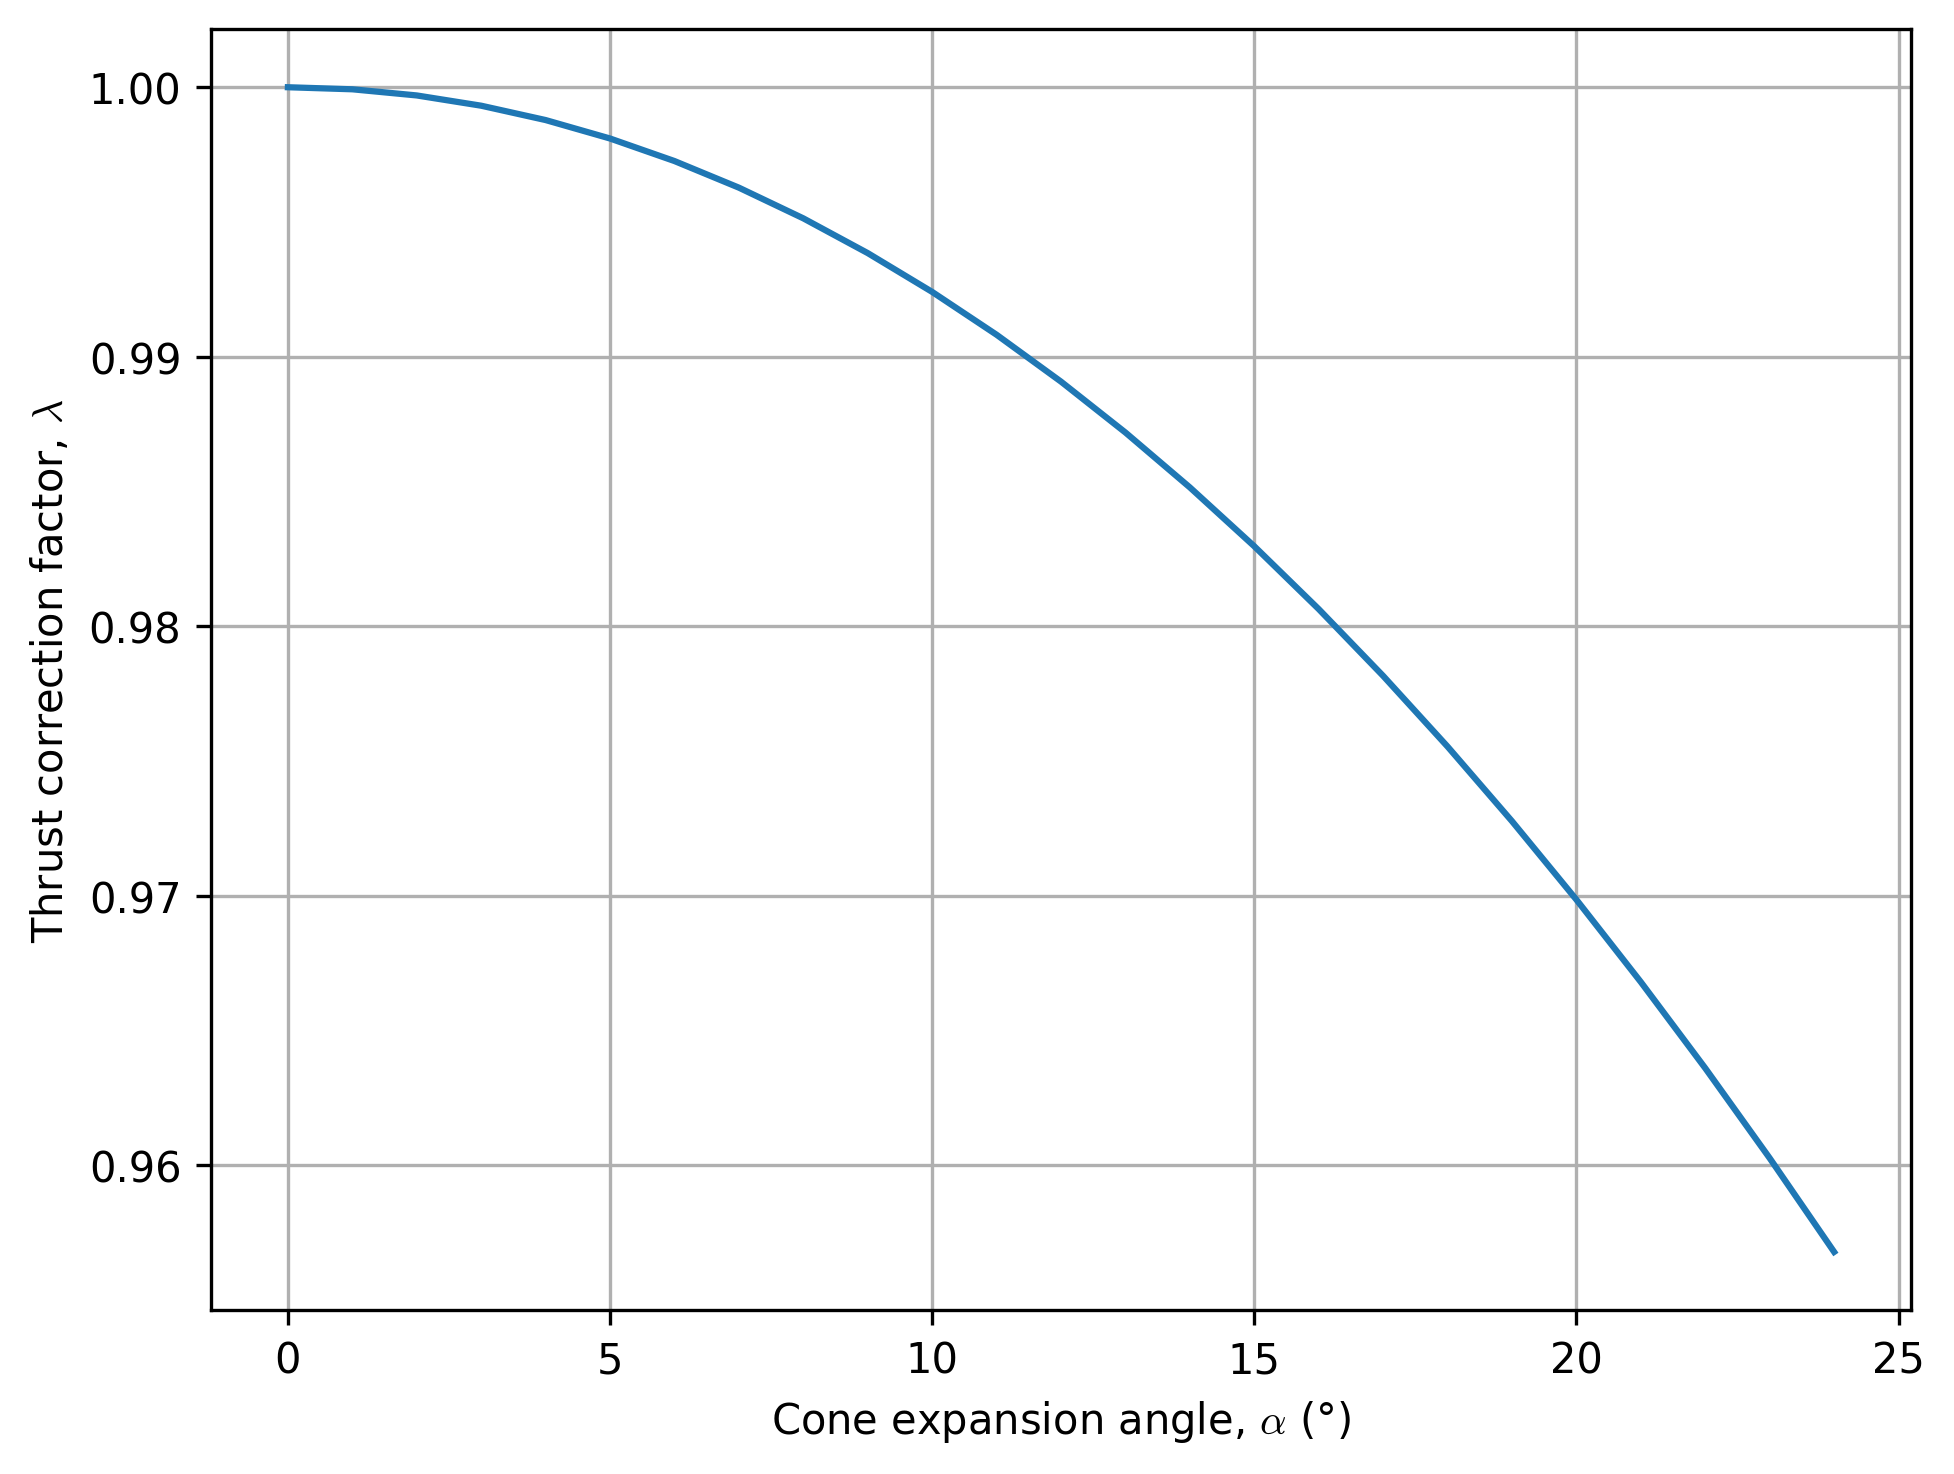

In [10]:
fig, ax = plt.subplots(layout="constrained")

alphas = np.arange(0, 25, 1)
lambdas = 0.5 * (1 + np.cos(np.radians(alphas)))

ax.plot(alphas, lambdas)
ax.set_xlabel(r'Cone expansion angle, $\alpha$ (°)')
ax.set_ylabel(r'Thrust correction factor, $\lambda$')
ax.grid(True)
plt.show()

A larger expansion angle leads to further deviation from the ideal thrust, since the nozzle is directing more of the flow in a non-useful direction. For a 15° cone, the correction factor is 0.983, meaning a loss of 1.7% of the thrust.

While this seems small, and likely negligible for a small-scale rocket, even a loss of this size is quite impactful on a larger vehicle. For example, the Falcon Heavy has a total sea-level thrust of 22.82 MN, meaning using conical nozzles would lead to a loss of nearly 388 kN of thrust. In terms of weight and mass, this would correspond to nearly 40,000 kg, or nearly the same order as the full vehicle's payload to low Earth orbit.

The other limitation is length: a conical nozzle is essentially the longest (and therefore heaviest) nozzle shape. A larger angle can reduce the length, but reduces thrust. A typical angle range of 12–18° balances these competing objectives.

### Bell nozzle 

A bell-shaped, or contour, nozzle, is the design used most commonly in larger rockets. 

:::{figure} ../images/bell-nozzle.svg
:label: fig-bell-nozzle
:alt: Diagram of a bell or contour nozzle
:align: center
:width: 100%

Bell or contoured nozzle, showing the initial radius of converging section ($r_c$), throat radius ($r_t$), and exit radius ($r_e$), as well as initial angle of diverging section ($\theta_i$) and final angle at the exit ($\theta_e$).
:::

The goal of a bell nozzle is to turn the flow gradually and make it nearly axial at the exit, reducing divergence losses. From our understanding of compressible flows, we know that the changing geometry in the supersonic, diverging section of the nozzle will initially start with continuous expansion/Mach waves, and then compression Mach waves to turn the flow horizontal. A long, gradual contour can ensure the flow remains isentropic, with smooth angles for all Mach waves; sharp angles would lead to oblique shocks. However, creating fully axial flow would require a very long, heavy nozzle, which is more appropriate for a large ground-based supersonic wind tunnel than on a rocket.

For rockets, we need shorter nozzles to minimize the inert mass. **Minimum-length nozzles** condense  all the flow expansion to a single point right after the throat, with the initial wall angle

$$
\theta_{w_{\max, \text{ML}}} = \frac{\nu_{M_e}}{2} \;,
$$

where $M_e$ is the exit Mach number and $\nu(M)$ is the [Prandtl--Meyer function](https://kyleniemeyer.github.io/gas-dynamics-notes/compressible-flows/prandtl-meyer.html):

$$
\nu(M) = \left( \frac{\gamma+1}{\gamma-1}\right)^{1/2} \tan^{-1} \left[ \frac{\gamma-1}{\gamma+1} (M^2 - 1) \right]^{1/2} - \tan^{-1} (M^2 - 1)^{1/2} \;.
$$

The wall shape and length can then be found using the [method of characteristics](https://kyleniemeyer.github.io/gas-dynamics-notes/compressible-flows/method-characteristics.html).

However, most shortened/truncated bell nozzles are not the absolute minimum length, but end at some percentage of the associated 15° conical nozzle length (e.g., 60%, 80%). These start with an arc at the throat with a large initial expansion angle ($\theta_i = $ 20–50°), which rapidly expands the flow, followed by a slower expansion at a more-gradual parabolic-like curve to a small angle near the exit ($\theta_e = $ <10°). These are based on the work of Rao {cite:p}`Rao58; Rao61`, who showed that a parabola can effectively approximate the ideal contour.


### Example: design of minimum-length bell nozzle

In [11]:
def get_prandtl_meyer(mach, gamma=1.4):
    '''Evaluate Prandtl-Meyer function at given Mach number and gamma.
    
    Defined as the angle from the flow direction where Mach = 1 through which the 
    flow turned isentropically reaches the specified Mach number.
    '''
    return (
        np.sqrt((gamma + 1.) / (gamma - 1.)) *
        np.arctan(np.sqrt((gamma - 1.)*(mach**2 - 1.)/(gamma + 1.))) -
        np.arctan(np.sqrt(mach**2 - 1.))
        )

def solve_mach_prandtl_meyer(mach, nu, gamma=1.4):
    '''Solve for unknown Mach number, given Prandtl-Meyer function (in radians).'''
    return (nu - get_prandtl_meyer(mach, gamma))

In [12]:
gamma = 1.4
mach_exit = 2.4

area_ratio = np.pow(
    (1 + 0.5*(gamma - 1) * mach_exit**2) / (0.5*(gamma + 1)), 
    (gamma + 1) / (2*(gamma-1))
    ) / mach_exit

angle_max = 0.5 * get_prandtl_meyer(mach_exit, gamma)
print(f'theta_w,max,ML = {np.degrees(angle_max): 5.4f}°')

theta_w,max,ML =  18.3733°


In [13]:
## Example for computing contour of minimum-length nozzle for accelerating air to Mach = 2.4
from scipy.optimize import root_scalar

delta_theta0 = np.radians(0.3733)
num_lines = 7
num_points = num_lines * (num_lines - 2)

nus = np.zeros(num_points)
thetas = np.zeros(num_points)
machs = np.zeros(num_points)
mus = np.zeros(num_points)
y = np.zeros(num_points)
x = np.zeros(num_points)

constant_minus = np.zeros(num_lines)
constant_plus = np.zeros(num_lines)

# nozzle throat is at x=0, y=1

# first line and point
nus[0] = delta_theta0
thetas[0] = delta_theta0
sol = root_scalar(
    solve_mach_prandtl_meyer, x0=1.1, bracket=[1.000001, 10], 
    args=(nus[0], gamma),
    )
machs[0] = sol.root
mus[0] = np.arcsin(1. / machs[0])
constant_minus[0] = thetas[0] + nus[0]
constant_plus[0] = thetas[0] - nus[0]
x[0] = -1. / np.tan(0.5*thetas[0] - 0.5*(np.pi/2. + mus[0]))
y[0] = 0.

# remaining points and lines in initial expansion fan
delta_theta = (angle_max - delta_theta0) / (num_lines - 1)
for idx in range(1, num_lines):
    thetas[idx] = thetas[idx-1] + delta_theta
    nus[idx] = thetas[idx]
    sol = root_scalar(
            solve_mach_prandtl_meyer, x0=1.1, bracket=[1.00001, 10], 
            args=(nus[idx], gamma),
            )
    machs[idx] = sol.root
    mus[idx] = np.arcsin(1. / machs[idx])
    constant_minus[idx] = thetas[idx] + nus[idx]
    
    dydx_p = np.tan(
        0.5*(thetas[idx-1] + thetas[idx]) + 0.5*(mus[idx-1] + mus[idx])
        )
    dydx_m = np.tan(thetas[idx] - mus[idx])
    y[idx] = (
        dydx_p*(-1. / dydx_m - x[idx-1]) + y[idx-1]
        ) / (1 - dydx_p / dydx_m)
    x[idx] = (y[idx] - 1.) / dydx_m

# point along upper surface
idx = num_lines
thetas[idx] = thetas[idx-1]
nus[idx] = nus[idx-1]
machs[idx] = machs[idx-1]
mus[idx] = mus[idx-1]
dydx_m = np.tan(0.5*(angle_max + thetas[idx]))
dydx_p = np.tan(
    0.5*(thetas[idx-1] + thetas[idx]) + 0.5*(mus[idx-1] + mus[idx])
    )
y[idx] = (dydx_p*(-x[idx-1] - 1./dydx_m) + y[idx-1]) / (1. - dydx_p/dydx_m)
x[idx] = (y[idx] - 1) / dydx_m

# remaining lines
idk = num_lines
for idx in range(1, num_lines):
    for idy in range(idx, num_lines):
        idk += 1
        if idy == idx:
            # along centerline
            thetas[idk] = 0
            nus[idk] = constant_minus[idx]
            constant_plus[idx] = thetas[idk] - nus[idk]
        else:
            thetas[idk] = 0.5*(constant_minus[idy] + constant_plus[idx])
            nus[idk] = 0.5*(constant_minus[idy] - constant_plus[idx])

        sol = root_scalar(
            solve_mach_prandtl_meyer, x0=1.1, bracket=[1.0001, 10], 
            args=(nus[idk], gamma),
            )
        machs[idk] = sol.root
        mus[idk] = np.arcsin(1. / machs[idk])
        
        idk_prev = idk - (num_lines - idx + 1)
        if idy == idx:
            y[idk] = 0.
            x[idk] = (
                x[idk_prev] - y[idk_prev] / np.tan(thetas[idk_prev] - mus[idk_prev])
            )
        else:
            dydx_p = np.tan(
                0.5*(thetas[idk-1] + thetas[idk]) + 0.5*(mus[idk-1] + mus[idk])
                )
            dydx_m = np.tan(
                0.5*(thetas[idk] + thetas[idk_prev]) - 0.5*(mus[idk] + mus[idk_prev])
                )
            y[idk] = (
                dydx_p*(-y[idk_prev] / dydx_m + x[idk_prev] - x[idk-1]) + y[idk-1]
                ) / (1. - dydx_p / dydx_m)
            x[idk] = x[idk_prev] + (y[idk] - y[idk_prev]) / dydx_m
    # wall
    idk += 1
    thetas[idk] = thetas[idk-1]
    nus[idk] = nus[idk-1]
    machs[idk] = machs[idk-1]
    mus[idk] = mus[idk-1]
    
    idk_prev = idk - (num_lines - idx + 1)
    dydx_m = np.tan(0.5*(thetas[idk_prev] + thetas[idk]))
    dydx_p = np.tan(
        0.5*(thetas[idk-1] + thetas[idk]) + 0.5*(mus[idk-1] + mus[idk])
        )
    y[idk] = (
        dydx_p*(-y[idk_prev] / dydx_m + x[idk_prev] - x[idk-1]) + y[idk-1]
        ) / (1. - dydx_p / dydx_m)
    x[idk] = x[idk_prev] + (y[idk] - y[idk_prev]) / dydx_m

err = 100.*np.abs(y[-1] - area_ratio) / area_ratio
print(f'Computed exit Mach number = {machs[-1]: .3f}')
print(f'Error in area ratio: {err: 6.3f}%')


Computed exit Mach number =  2.400
Error in area ratio:  0.554%


In [14]:
print(f'Nozzle length: {x[-1]: .3f}')

Nozzle length:  8.064


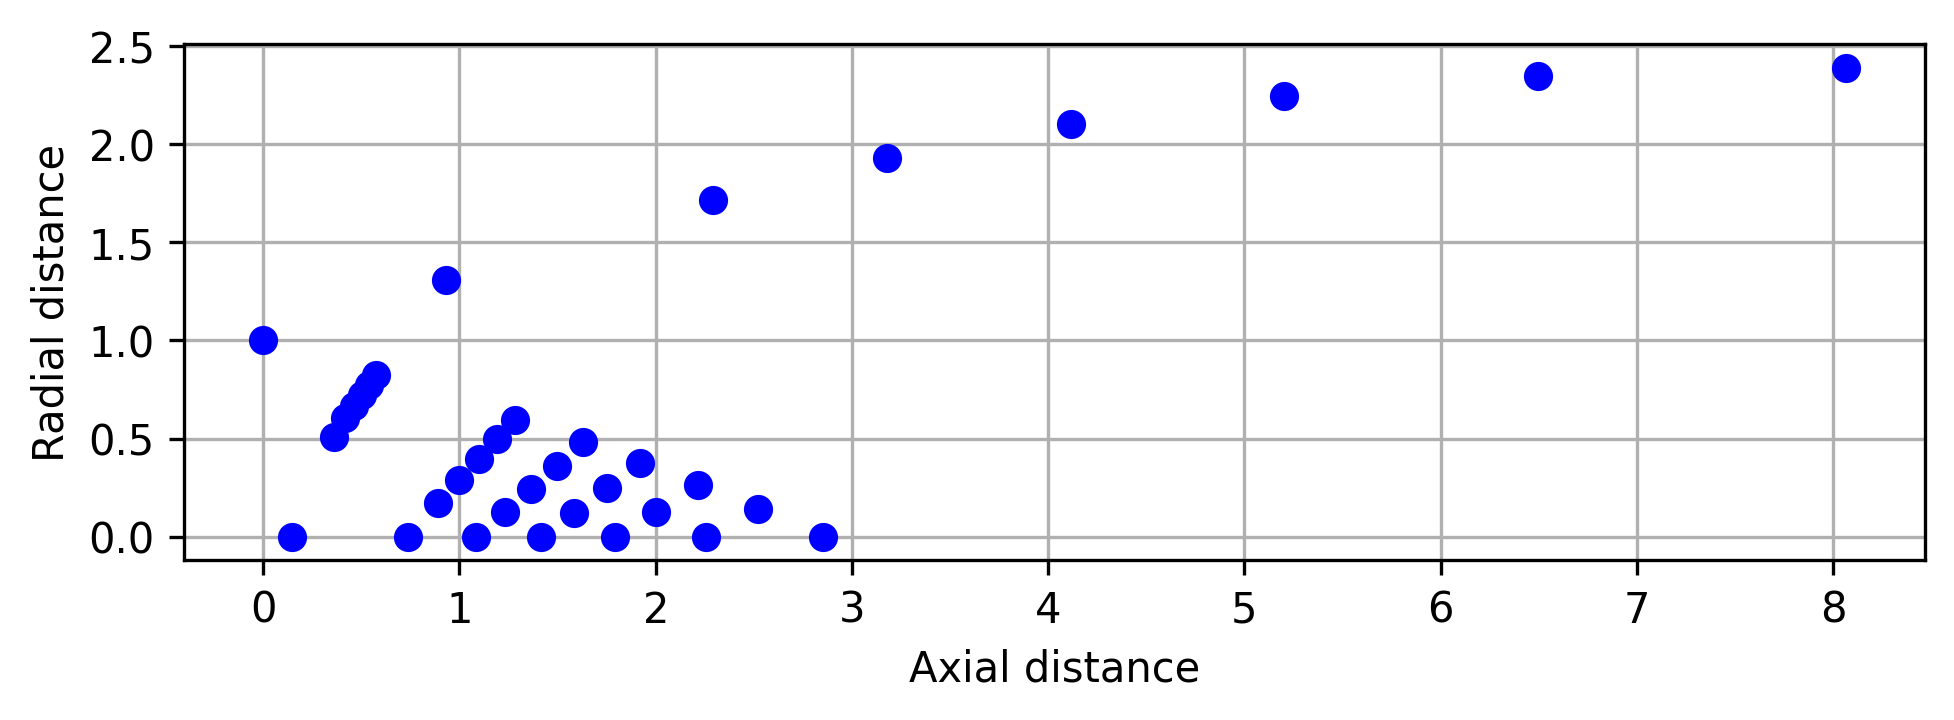

In [15]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(x, y, 'o', color='b')
# add point for nozzle throat at x=0, y=1
ax.plot(0.0, 1.0, 'o', color='b')
ax.set_xlabel('Axial distance')
ax.set_ylabel('Radial distance')
ax.set_aspect('equal', 'box')
ax.grid(True)
plt.show()

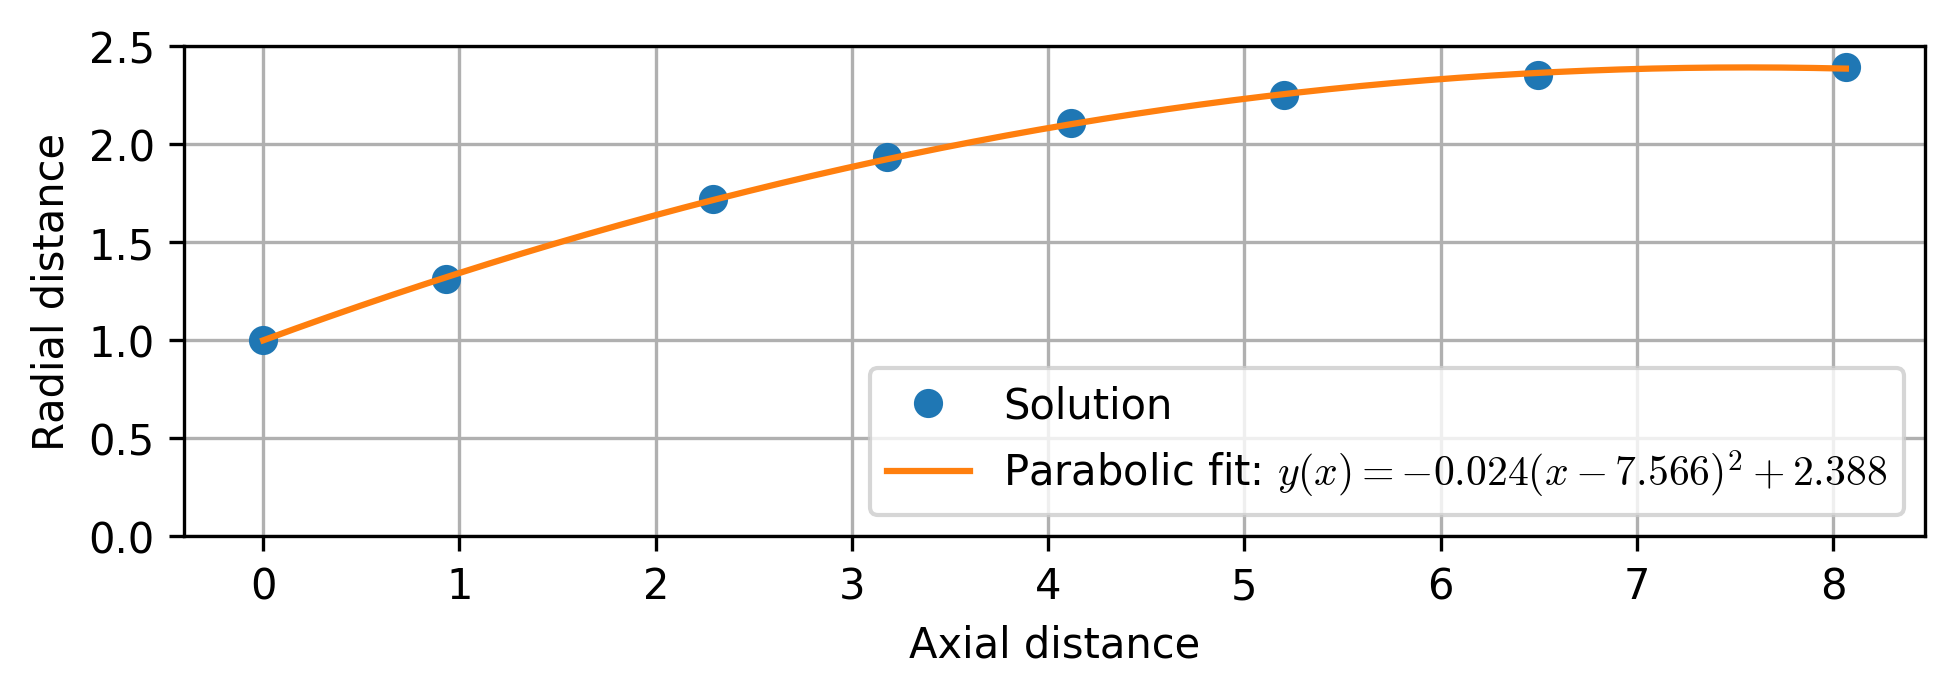

In [16]:
from scipy.optimize import curve_fit

# extract wall nodes
x_wall = np.zeros(num_lines + 1)
y_wall = np.zeros_like(x_wall)
x_wall[0] = 0.0
y_wall[0] = 1.0

idk = -1
for idx in range(num_lines):
    idk += num_lines + 1 - idx
    x_wall[idx+1] = x[idk]
    y_wall[idx+1] = y[idk]


# fit parabola
def parabola(x, a, b, c):
    return(a * np.pow(x - b, 2) + c)

popt, pcov = curve_fit(parabola, x_wall, y_wall)
xdata = np.linspace(0, np.max(x_wall))
ydata = parabola(xdata, *popt)
a, b, c = popt

fig, ax = plt.subplots(layout='constrained')
ax.plot(x_wall, y_wall, 'o', label='Solution')
ax.plot(
    xdata, ydata, 
    label=fr'Parabolic fit: $y(x) = {a: .3f} (x - {b: .3f})^2 + {c: .3f}$')
ax.set_xlabel('Axial distance')
ax.set_ylabel('Radial distance')
ax.set_aspect('equal', 'box')
ax.set_ylim([0, 2.5])
ax.grid(True)
ax.legend(loc='lower right')
plt.show()

## Plug nozzles

Also called **aerospike nozzles**.

## Extendable nozzles

Extendable nozzles have been proposed to adapt to changing ambient pressures. Lower ambient pressures, such as near-vacuum, require a longer nozzle to avoid overexpansion. In an expandable nozzle, the diverging section is split into two pieces, and the lower (larger) section is moved into pace at higher altitudes to extend the nozzle.

Alternatively, a droppable insert could be used, which has a droppable smaller nozzle inside a larger one. Initially, the inner nozzle keeps the exit area smaller, but then the insert is released and drops away. This has some practical engineering challenges and creates debris.

These extendable nozzle concepts have been researched but not demonstrated practically.